In [22]:
from langchain_ollama import ChatOllama

from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import interrupt
from dotenv import load_dotenv
import os
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from pydantic import BaseModel
from typing import List

from IPython.display import Image, display

In [339]:
load_dotenv()
tavily_api_key = os.getenv("tavily_api_key")

llm = ChatOllama(
    model="granite3.2:8b-instruct-fp16",
    frequency_penalty= 0,
    max_tokens= 10,
    presence_penalty= 0,
    temperature= 1,
    top_p= 1
)

llm.invoke("what is the capital of Iran")

AIMessage(content='The capital of Iran is Tehran.', additional_kwargs={}, response_metadata={'model': 'granite3.2:8b-instruct-fp16', 'created_at': '2025-03-14T03:28:53.9320043Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1098039300, 'load_duration': 20585700, 'prompt_eval_count': 50, 'prompt_eval_duration': 377000000, 'eval_count': 11, 'eval_duration': 690000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-3a1f3b22-e121-40ba-99e4-7808474a2d35-0', usage_metadata={'input_tokens': 50, 'output_tokens': 11, 'total_tokens': 61})

In [ ]:
class AgentState(TypedDict):
    function_str: str
    #latex_str:str
    #value: float
    user_message : str
    messages: Annotated[list, add_messages]


def greeting(AgentState )-> str:
    template = "you are a value extraction assistant. Greet the user and write a sentence about importance of math in life." \
    "Then ask for a mathematical function that you can evaluate written in a bracket."

    messages  = [SystemMessage(content=template)] + AgentState["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}



# def user_enter_function(AgentState):
#     print("--- Waiting for FUNCTION ---")
#     function_str = input("Please ENTER FUNCTION: ")
#     AgentState["function_str"]=function_str

#     AgentState["messages"]  = [HumanMessage(content=function_str)] + AgentState["messages"]  #+[SystemMessage(content="I GOT It!")]


#     return AgentState


# #https://langchain-ai.github.io/langgraph/how-tos/wait-user-input-functional/#usage
# def user_enter_function(AgentState):

#     global counter
#     counter += 1
#     print(f"> Entered the node: {counter} # of times")

#     #print("---human_feedback---")
#     function_str = interrupt("Please enter function:")

#     function_str = input("Please ENTER FUNCTION: ")


#     AgentState["messages"]  = [HumanMessage(content=function_str)] + AgentState["messages"]
#     AgentState["function_str"]=function_str

#     return {
#         "function_str": function_str
#     }

    

def explain_function(AgentState):

    prompt = f" You are a math expert. You know about the history of math, and famous mathematicians in history. Your job is to tell\
        a fact or story about the function {AgentState["function_str"]}"
    response = llm.invoke(prompt)
    messages  =  [response] + AgentState["messages"]
    
    return {"messages": messages}


In [343]:
graph_builder = StateGraph(AgentState)
graph_builder.add_node("greeting", greeting)
graph_builder.add_node("user_enter_function", user_enter_function)
graph_builder.add_node("explain_function", explain_function)


graph_builder.add_edge(START,"greeting")
graph_builder.add_edge("greeting","user_enter_function")
graph_builder.add_edge("user_enter_function", "explain_function")
graph_builder.add_edge("explain_function", END)


memory = MemorySaver()
graph = graph_builder.compile(checkpointer = memory)

config = {"configurable":{"thread_id":1}}

In [344]:
counter=0

user_input = input("You: ")
input_message = {"messages": [HumanMessage(content=user_input)]}

for chunk in graph.stream(input_message, stream_mode="values",config = config):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

hi
================================== Ai Message ==================================

Hello! Math is absolutely essential in our daily lives, shaping our understanding of the world and enabling us to make sense of complex situations. It's used extensively in fields like science, engineering, economics, and even in everyday tasks such as cooking or managing finances. 

Now, could you please provide me with a mathematical function enclosed in brackets that I can evaluate for you? For example, you might ask for the evaluation of something like "sin(30)" or "2^5".
> Entered the node: 1 # of times


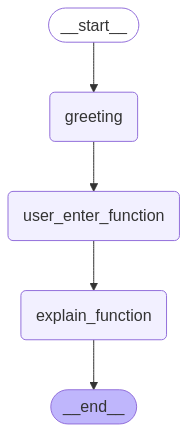

In [200]:
display(graph)

In [328]:
counter = 0
def node(state):
    # All the code from the beginning of the node to the interrupt will be re-executed
    # when the graph resumes.
    global counter
    counter += 1
    print(f"> Entered the node: {counter} # of times")
    # Pause the graph and wait for user input.
    answer = interrupt()
    print("The value of counter is:", counter)
    ...